# Feature Selection and Reduced Feature Models #

In this notebook I will reduce the number of features used and re-run some models to see if I can get better, or equal results.

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns
import graphviz

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import tree
from sklearn import ensemble
from sklearn.linear_model import Ridge

In [2]:
# read in data set with categorical variables turned into dummy variablees
df = pd.read_csv('data/cleaned_data/md_dum.csv')

# create X and y values for modeling, this time using a mask to create 1 and 0 values for classification
car_y = df.car_acc_score
car_c_y = df.car_acc_score.mask(df.car_acc_score > 0, 1)
car_X = df.drop(columns=['Unnamed: 0', 'car_acc_score', 'car_dens_score', 'bike_dens_score'])
bike_y = df.bike_acc_score
bike_c_y = df.bike_acc_score.mask(df.bike_acc_score > 0, 1)
bike_X = df.drop(columns=['Unnamed: 0', 'bike_acc_score', 'car_dens_score', 'bike_dens_score'])

In [3]:
# do train test split on classification
# train test split
X_car_c_train, X_car_c_test, y_car_c_train, y_car_c_test = train_test_split(car_X, car_c_y, test_size=0.3, 
                                                                            random_state=18,
                                                                            shuffle=True, stratify=car_c_y)
X_bike_c_train, X_bike_c_test, y_bike_c_train, y_bike_c_test = train_test_split(bike_X, bike_c_y, test_size=0.3, 
                                                                            random_state=18,
                                                                            shuffle=True, stratify=bike_c_y)

In [22]:
# perform decision tree classifier on car data
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_car_c_train, y_car_c_train)
dtc.score(X_car_c_test, y_car_c_test)

0.886900211359446

In [23]:
# show the top 20 features for car classifying
car_feature_importances = dtc.feature_importances_
car_feature_names, car_feature_scores = zip(*sorted(zip(X_car_c_train.columns, car_feature_importances), 
                                                          key=lambda x: -x[1]))
car_features = pd.DataFrame({'feature_names' : car_feature_names, 'score' : car_feature_scores}).set_index('feature_names').sort_values(by='score')
car_features.tail(20)

,score
feature_names,
Struct_Cnd_3,0.001905
Op_Dir_SL,0.001971
Jurisdictn_2,0.002047
Route_Direction_NB,0.002275
Struct_Cnd_2,0.002572
City_Maint_35,0.002732
Med_Width,0.002823
Route_System_L,0.002824
Terrain_1,0.003125


In [32]:
#build smaller feature set
#read in data set before making dummies
sel_df = pd.read_csv('data/cleaned_data/model_df.csv')
sel_df = sel_df[['car_acc_score', 'traffic_density', 'bike_acc_score', 'AADT', 'ROW_Width', 'Surface_Wd', 'Surface_Tp', 
                'Rt_Sidewlk', 'Lt_Sidewlk', 'Route_System', 'Route_Direction', 'Struct_Cnd', 'Terrain',
                'Route_System', 'Med_Width', 'City_Maint', 'Jurisdictn', 'Op_Dir_SL']]
sel_dum = pd.get_dummies(sel_df, columns=['Route_System', 'Route_Direction', 'Struct_Cnd', 'Terrain',
                'Route_System', 'City_Maint', 'Jurisdictn'])
sel_dum.head()

,car_acc_score,bike_acc_score,traffic_density,bike_acc_score,AADT,ROW_Width,Surface_Wd,Surface_Tp,Rt_Sidewlk,Lt_Sidewlk,...,City_Maint_274,City_Maint_314,Jurisdictn_0,Jurisdictn_1,Jurisdictn_2,Jurisdictn_3,Jurisdictn_5,Jurisdictn_B,Jurisdictn_E,Jurisdictn_H
0,1,10,1.707255,10,1154.0,50.0,28.0,5,4.0,4.0,...,0,0,0,0,1,0,0,0,0,0
1,0,4,0.186701,4,1154.0,50.0,28.0,5,4.0,4.0,...,0,0,0,0,1,0,0,0,0,0
2,0,1,0.345786,1,1154.0,50.0,28.0,5,4.0,4.0,...,0,0,0,0,1,0,0,0,0,0
3,1,10,0.470252,10,3598.0,55.0,30.0,7,5.0,5.0,...,0,0,0,0,1,0,0,0,0,0
4,0,1,2.013781,1,3598.0,55.0,30.0,7,5.0,5.0,...,0,0,0,0,1,0,0,0,0,0


In [34]:
# now lets see if my best regressor runs any better on this reduced set
car_y = sel_dum.car_acc_score
car_X = sel_dum.drop(columns=['car_acc_score'])
# do train test split
X_car_train, X_car_test, y_car_train, y_car_test = train_test_split(car_X, car_y, test_size=0.3, random_state=18,
                                                                   shuffle=True, stratify=car_y)

In [35]:
rfr = ensemble.RandomForestRegressor()
rfr.fit(X_car_train, y_car_train)
car_score = rfr.score(X_car_test, y_car_test)
print('Random Forest Regression Score on car accidents: {}'.format(car_score))

Random Forest Regression Score on car accidents: 0.15048841207650787


That is definitely better than before, 0.1, but not wildly better. Let's try our best linear regressor.

In [37]:
ri = Ridge()
ri.fit(X_car_train, y_car_train)
ri_score = ri.score(X_car_test, y_car_test)
print('Ridge Regression Score on car accidents is: {}'.format(ri_score))

Ridge Regression Score on car accidents is: 0.05766207965891612


Not much better. Okay, classification still seems like the better bet.

In [49]:
car_c_y = sel_dum.car_acc_score.mask(sel_dum.car_acc_score > 0, 1)

# do train test split
X_car_c_train, X_car_c_test, y_car_c_train, y_car_c_test = train_test_split(car_X, car_c_y, test_size=0.3, 
                                                                            random_state=18,
                                                                            shuffle=True, stratify=car_c_y)

In [50]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_car_c_train, y_car_c_train)
dtc.score(X_car_c_test, y_car_c_test)

0.8879345235418447

In [51]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_car_c_train, y_car_c_train)
score = rfc.score(X_car_c_test, y_car_c_test)
print('Random Forest Classifier accuracy score is {}'.format(score))

Random Forest Classifier accuracy score is 0.8927912937896298


In [52]:
bc = ensemble.BaggingClassifier()
bc.fit(X_car_c_train, y_car_c_train)
score = bc.score(X_car_c_test, y_car_c_test)
print('Bagging Classifier accuracy score is {}'.format(score))

Bagging Classifier accuracy score is 0.8930161442640644


Gradient Boosting Score: 0.8833026037684939
[[11382  1101]
 [ 1494  8260]]


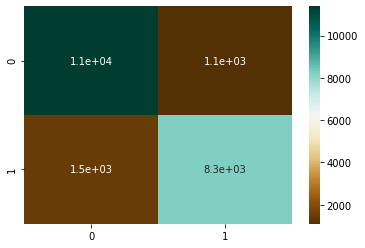

In [42]:
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_car_c_train, y_car_c_train)
print('Gradient Boosting Score: {}'.format(gbc.score(X_car_c_test, y_car_c_test)))
pred = gbc.predict(X_car_c_test)
c=confusion_matrix(y_car_c_test, pred)
print(c)
sns.heatmap(c,cmap='BrBG',annot=True)
plt.show()

In [24]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_bike_c_train, y_bike_c_train)
dtc.score(X_bike_c_test, y_bike_c_test)

0.9033592660880514

In [26]:
# show the top 20 features for bike classifying
bike_feature_importances = dtc.feature_importances_
bike_feature_names, bike_feature_scores = zip(*sorted(zip(X_bike_c_train.columns, bike_feature_importances), 
                                                          key=lambda x: -x[1]))
bike_features = pd.DataFrame({'feature_names' : bike_feature_names, 'score' : bike_feature_scores}).set_index('feature_names').sort_values(by='score')
bike_features.tail(20)

,score
feature_names,
F_Class_3,0.002832
Terrain_1,0.003195
Operation_2,0.003557
Operation_-1,0.003628
Operation_1,0.003758
Route_Direction_NB,0.003764
Struct_Cnd_1,0.003941
Struct_Cnd_2,0.005416
Op_Dir_SL,0.005462


In [44]:
#build smaller feature set
#read in data set before making dummies
bike_df = pd.read_csv('data/cleaned_data/model_df.csv')
bike_df = bike_df[['car_acc_score', 'bike_acc_score', 'AADT', 'City', 'ROW_Width', 'Surface_Wd', 
                 'Jurisdictn', 'Rt_Sidewlk', 'Lt_Sidewlk', 'Route_Direction', 'Med_Width',
                 'Op_Dir_SL', 'Struct_Cnd', 'Operation', 'Terrain', 'F_Class']]
bike_dum = pd.get_dummies(bike_df, columns=['City', 'Jurisdictn', 'Route_Direction', 'Struct_Cnd',
                                         'Operation', 'Terrain', 'F_Class'])
bike_dum.head()

,car_acc_score,bike_acc_score,AADT,ROW_Width,Surface_Wd,Rt_Sidewlk,Lt_Sidewlk,Med_Width,Op_Dir_SL,City_-1,...,Terrain_1,Terrain_2,Terrain_3,F_Class_-1,F_Class_0,F_Class_1,F_Class_2,F_Class_3,F_Class_5,F_Class_6
0,1,10,1154.0,50.0,28.0,4.0,4.0,0.0,30,0,...,1,0,0,0,1,0,0,0,0,0
1,0,4,1154.0,50.0,28.0,4.0,4.0,0.0,30,0,...,1,0,0,0,1,0,0,0,0,0
2,0,1,1154.0,50.0,28.0,4.0,4.0,0.0,30,0,...,1,0,0,0,1,0,0,0,0,0
3,1,10,3598.0,55.0,30.0,5.0,5.0,0.0,99,0,...,1,0,0,0,0,0,0,0,0,1
4,0,1,3598.0,55.0,30.0,5.0,5.0,0.0,99,0,...,1,0,0,0,0,0,0,0,0,1


In [45]:
# now lets see if my best regressor runs any better on this reduced set
bike_y = bike_dum.bike_acc_score
bike_X = bike_dum.drop(columns=['bike_acc_score'])
# do train test split
X_bike_train, X_bike_test, y_bike_train, y_bike_test = train_test_split(bike_X, bike_y, test_size=0.3, random_state=18,
                                                                   shuffle=True, stratify=bike_y)

In [47]:
rfr = ensemble.RandomForestRegressor()
rfr.fit(X_bike_train, y_bike_train)
bike_score = rfr.score(X_bike_test, y_bike_test)
print('Random Forest Regression Score on car accidents: {}'.format(bike_score))

Random Forest Regression Score on car accidents: 0.3114562984892384


In [48]:
ri = Ridge()
ri.fit(X_bike_train, y_bike_train)
ri_score = ri.score(X_bike_test, y_bike_test)
print('Ridge Regression Score on car accidents is: {}'.format(ri_score))

Ridge Regression Score on car accidents is: 0.07096354190730414


In [53]:
bike_c_y = bike_dum.bike_acc_score.mask(bike_dum.car_acc_score > 0, 1)

# do train test split
X_bike_c_train, X_bike_c_test, y_bike_c_train, y_bike_c_test = train_test_split(bike_X, bike_c_y, test_size=0.3, 
                                                                            random_state=18,
                                                                            shuffle=True, stratify=bike_c_y)

In [54]:
dtc = tree.DecisionTreeClassifier()
dtc.fit(X_bike_c_train, y_bike_c_train)
dtc.score(X_bike_c_test, y_bike_c_test)

0.8749381661195305

In [55]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_bike_c_train, y_bike_c_train)
score = rfc.score(X_bike_c_test, y_bike_c_test)
print('Random Forest Classifier accuracy score is {}'.format(score))

Random Forest Classifier accuracy score is 0.8755677474479471


In [56]:
bc = ensemble.BaggingClassifier()
bc.fit(X_bike_c_train, y_bike_c_train)
score = bc.score(X_bike_c_test, y_bike_c_test)
print('Bagging Classifier accuracy score is {}'.format(score))

Bagging Classifier accuracy score is 0.8739038539371318
